# Special case: gaseous species
In this special case tutorial we will discuss how to handle gaseous compounds both in the in- and outlet of the reactor, the most common molecules of this type is CO2 and O2. These species are  not accounted for in the feed medium and since they evaporate the liquid concentration does not account for all the produced mass. Thus, we setup the full mass balance for the species.

$$
\frac{dM_{species}}{dt}=In_{gas}+In_{liquid}-Out_{gas}+Metabolism-Sampled
$$
where $M_{species}$ is the total amount of species in the reactor in both gas and aqueous phase. The term metabolism is the net value and covers both production (positive) and consumption (negative). If we integrate the mass balance we get the following:

$$
M_{species}(t)=\int_0^t In_{gas}+\int_0^t In_{liquid}-\int_0^t Out_{gas}+\int_0^t Metabolism-\int_0^t Sampled
$$

Data about the gaseous entering and leaving a bioreactor is usually expressed in terms of total amount over time. However, the pseudo batch transformation can only work with concentrations and therefore we treat these species as entirely solubilized and assign them a “hypothetical concentration”, which we then perform the pseudobatch correction on.

The pseudobatch package presents a function to preprocess the in- and outlet gas data into a hypothetical concentration, which can be transformed with the pseudobatch transformation. In this tutorial we will go through three examples

1. Highly insoluble produced compound, exemplified by $CO_2$
2. Highly insoluble consumed compound, exemplified by $O_2$
3. Partially insoluble compound, exemplified by a generic product

Now, we are ready to setup the programming environment and load the data.


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from pseudobatch import pseudobatch_transform_pandas, hypothetical_concentration, metabolised_amount
from pseudobatch.datasets import load_volatile_compounds_fedbatch

/Users/s143838/.virtualenvs/pseudobatch-dev/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'stan_version_major': '2', 'stan_version_minor': '29', 'stan_version_patch': '2', 'STAN_THREADS': 'false', 'STAN_MPI': 'false', 'STAN_OPENCL': 'false', 'STAN_NO_RANGE_CHECKS': 'false', 'STAN_CPP_OPTIMS': 'false'}


In [2]:
fedbatch_df = load_volatile_compounds_fedbatch()

## Transforming a highly insoluble produced compound, $CO_2$

The test dataset contain simulated the accumulated $CO_2$ production measurements in mass units in the column `m_CO2_gas`. Further, we se that the concentration of CO2 in the liquid phase is zero at all times. This is because in the simulation we assume that CO2 evaporated immediately after production as was stated earlier.

array([[<Axes: xlabel='timestamp'>],
       [<Axes: xlabel='timestamp'>]], dtype=object)

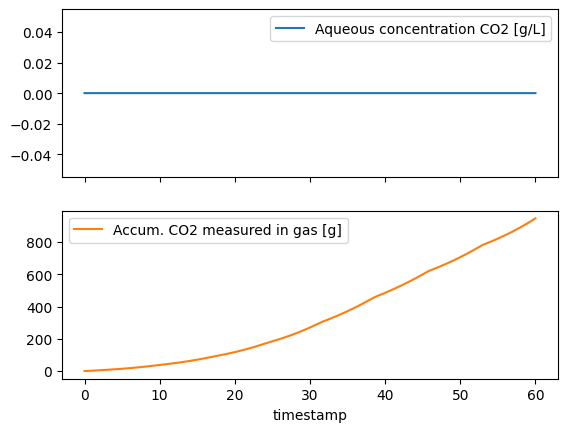

In [3]:
fedbatch_df.plot(x='timestamp', y=['c_CO2', 'm_CO2_gas'], subplots=True, layout=(2,1), label=['Aqueous concentration CO2 [g/L]', 'Accum. CO2 measured in gas [g]'])

Notice, how the production rate of CO2 (g/h) decrease the bioreactor is sampled. This is because the total amount of biomass decrease after sampling, thus there is less biomass to produce CO2. 

We assume that all $CO_2$ that exists the bioreactor is product of metabolism, i.e. no $CO_2$ is added through the liquid or gas feed. Therefore, we can directly calculate the hypothetical concentration.

In [4]:
fedbatch_df['hypothetical_c_CO2'] = hypothetical_concentration(
    metabolised_amount=fedbatch_df['m_CO2_gas'].to_numpy(),
    reactor_volume=fedbatch_df['v_Volume'].to_numpy(),
    sample_volume=fedbatch_df['sample_volume'].to_numpy()
)

Now, we can transform the hypothetical CO2 concentration and the biomass concentration measurements.

In [5]:
fedbatch_df[['pseudo_Biomass', 'pseudo_CO2']] = pseudobatch_transform_pandas(
    df=fedbatch_df,
    measured_concentration_colnames=["c_Biomass", "hypothetical_c_CO2"],
    reactor_volume_colname='v_Volume',
    accumulated_feed_colname='v_Feed_accum',
    concentration_in_feed=[0,0],
    sample_volume_colname='sample_volume'
)


If we estimate the CO2 yield using the pseudobatch transformed data we obtain the exact value used for the simulation.

In [6]:
Yxco2_hat, intercept = np.polyfit(fedbatch_df['pseudo_Biomass'], fedbatch_df['pseudo_CO2'], 1)
print(f"Yxco2_hat = {Yxco2_hat}")
print(f"true Yxco2 = {fedbatch_df['Yxco2'].iloc[-1]}")

Yxco2_hat = 0.045193332445214125
true Yxco2 = 0.0451933324452141


## Transforming insoluble consumed compound, Oxygen
Measurements of $O_2$ are typically obtained in the form of amount $O_2$ entering and exiting the reactor. However, we will account for both the dissolved and the sampled $O_2$. Therefore the mass balance becomes the following.
$$
Metabolism = Out + Sampled + Dissolved - In
$$
You can calculate the metabolized amount of $O_2$ on your own, but it does require special care to use the correct volume and mass' regarding before or after sampling. To ease the use we have made a function which calculates the metabolized amount for you.

At the sampling time points this dataset contains the values just before the sample was taken. However, the `metabolised_amount()` function requires the values from just after the sample withdrawal. In the following we calculate the $O_2$ mass after sample withdrawal.

In [7]:
fedbatch_df['m_O2_after_sample'] = fedbatch_df['m_O2'] - fedbatch_df['c_O2'] * fedbatch_df['sample_volume']

Here, we will use the `metabolised_amount()` function to calculate the mass of consumed $O_2$.

In [8]:
fedbatch_df['m_O2_consumed'] = metabolised_amount(
    off_gas_amount=fedbatch_df['m_O2_gas'].to_numpy(),
    dissolved_amount_after_sampling=fedbatch_df['m_O2_after_sample'].to_numpy(),
    inlet_gas_amount=fedbatch_df['m_O2_in'].to_numpy(),
    sampled_amount=(fedbatch_df['c_O2'] * fedbatch_df['sample_volume']).cumsum().to_numpy(),
)

Now, that we have calculated the metabolised amount of $O_2$ we can calculate the hypothetical concentration and run the pseudo batch transformation on the hypothetical concentration data.

In [9]:
fedbatch_df['hypothetical_c_O2'] = hypothetical_concentration(
    metabolised_amount=fedbatch_df['m_O2_consumed'].to_numpy(),
    reactor_volume=fedbatch_df['v_Volume'].to_numpy(),
    sample_volume=fedbatch_df['sample_volume'].to_numpy(),
)

fedbatch_df['pseudo_O2'] = pseudobatch_transform_pandas(
    df=fedbatch_df,
    measured_concentration_colnames=['hypothetical_c_O2'],
    reactor_volume_colname='v_Volume',
    accumulated_feed_colname='v_Feed_accum',
    concentration_in_feed=[0],
    sample_volume_colname='sample_volume',
)

We are now ready to estimate the oxygen yield coefficient using a linear model.

In [10]:
Yxo2_hat, intercept = np.polyfit(fedbatch_df['pseudo_Biomass'], fedbatch_df['pseudo_O2'], 1)
print(f"Yxo2_hat = {Yxo2_hat}")
print(f"true Yxo2 = {fedbatch_df['Yxo2'].iloc[-1]}")

Yxo2_hat = -0.010000000000000162
true Yxo2 = 0.01


## Volatile product
We simulated a generic volatile product which is produced in the liquid and then evaporates through first order kinetics. We will assume that we have measurements both of the evaporating amount and the liquid concentration of the product. 

Let's first inspect the raw simulated data.

<Axes: xlabel='timestamp'>

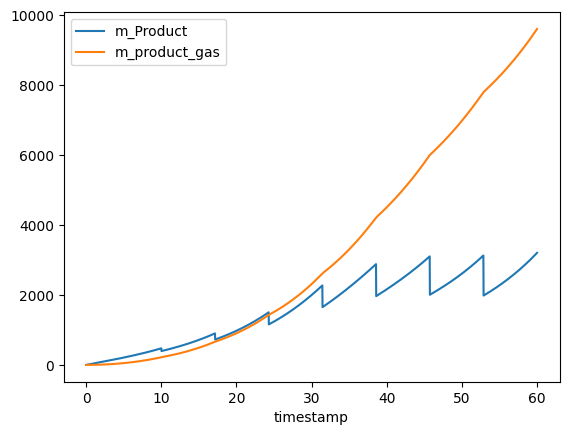

In [11]:
fedbatch_df.plot(
    x='timestamp',
    y=['m_Product', 'm_product_gas']
)

Some of the dissolved product (m_Product) is removed when the bioreactor is sampled, while the product that has evaporated is not removed through sampling. We need to calculate the total production of the product, i.e. combining the two curves above. We can use the `metabolised_amount()` to calculated the total production.

In [12]:
fedbatch_df['m_Product_after_sample'] = fedbatch_df['m_Product'].to_numpy() - (fedbatch_df['c_Product'] * fedbatch_df['sample_volume']).to_numpy()

fedbatch_df['m_Product_total'] = metabolised_amount(
    off_gas_amount=fedbatch_df['m_product_gas'].to_numpy(),
    dissolved_amount_after_sampling=fedbatch_df['m_Product_after_sample'].to_numpy(),
    inlet_gas_amount=np.zeros_like(fedbatch_df['m_Product']),
    sampled_amount=(fedbatch_df['c_Product'] * fedbatch_df['sample_volume']).cumsum().to_numpy(),
)
fedbatch_df['hypothetical_c_Product'] = hypothetical_concentration(
    metabolised_amount=fedbatch_df['m_Product_total'].to_numpy(),
    reactor_volume=fedbatch_df['v_Volume'].to_numpy(),
    sample_volume=fedbatch_df['sample_volume'].to_numpy()
)

Now that we have the hypothetical concentration we can perform pseudobatch transformation on the data.

In [13]:
fedbatch_df['pseudo_Product'] = pseudobatch_transform_pandas(
    df=fedbatch_df,
    measured_concentration_colnames='hypothetical_c_Product',
    reactor_volume_colname='v_Volume',
    accumulated_feed_colname='v_Feed_accum',
    concentration_in_feed=[0],
    sample_volume_colname='sample_volume'
)

Finally, we can estimate the product yield coefficient using a linear model.

In [14]:
Yxp_hat, intercept = np.polyfit(fedbatch_df['pseudo_Biomass'], fedbatch_df['pseudo_Product'], 1)
print(f"Yxp_hat = {Yxp_hat}")
print(f"true Yxp = {fedbatch_df['Yxp'].iloc[-1]}")

Yxp_hat = 0.8215102466751055
true Yxp = 0.8215102466751038


Again, we show that the estimated yield coefficient matches the coefficient that was used for the simulation.

Through out this tutorial we have shown that pseudobatch transformation is capable of handling measurements of gaseous compounds.